### Sundqvist Scheme

We split the data into two regimes and use Nelder-Mead.

We let the parameters depend on whether they are taken over land or over the sea.

Parameters optimized in two steps: 1) Manual optimization, 2) Nelder-Mead

--> I use the best set of parameters from the manually tuned code as a starting point

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

# Get the same result with 10**7
subset_size = 10**6

np.random.seed(10)

**Read data**

In [2]:
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
    
# Features
features = ['clw', 'cli', 'rh', 'pa', 'ps', 'fr_land']
no_features = len(features)

loc = {}
for i in range(len(features)):
    loc[features[i]] = i

In [3]:
path_data = os.path.join('/home/b/b309170/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND')

input_data = np.load(path_data + '/cloud_cover_input_dyamond.npy')
input_data = np.concatenate([np.expand_dims(input_data[:, loc_all[sel_var]], axis=1) for sel_var in features], axis = 1)

output_data = np.load(path_data + '/cloud_area_output_dyamond.npy')

In [4]:
(samples_total, no_of_features) = input_data.shape
(samples_total, no_of_features)

(285179494, 6)

In [5]:
# Construct training and validation data
training_folds = []
validation_folds = []
two_week_incr = samples_total//6

for i in range(3):
    # Note that this is a temporal split since time was the first dimension in the original tensor
    first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
    second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

    validation_folds.append(np.append(first_incr, second_incr))
    training_folds.append(np.arange(samples_total))
    training_folds[i] = np.delete(training_folds[i], validation_folds[i])

In [6]:
# The second fold yields the best model
flattened_input_train = input_data[training_folds[1]]
flattened_input_valid = input_data[validation_folds[1]]
flattened_output_train = output_data[training_folds[1]]
flattened_output_valid = output_data[validation_folds[1]]
    
# Remove input_data, output_data
del input_data, output_data, training_folds, validation_folds
gc.collect()

0

**Already remove the regime with clw + cli = 0**

In [7]:
reg_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] <= 1e-20)[0]
reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] > 1e-20)[0]
flattened_input_train = flattened_input_train[reg_not_0_train]
flattened_output_train = flattened_output_train[reg_not_0_train]

reg_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] <= 1e-20)[0]
reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] > 1e-20)[0]

# Relevant values to compute final MSE/R2-scores
mse_reg_0 = np.mean(flattened_output_valid[reg_0_valid]**2)
len_reg_0 = len(reg_0_valid)
len_reg_not_0 = len(reg_not_0_valid)
len_data_output = len(flattened_output_valid)
var_data_output = np.var(flattened_output_valid)

flattened_input_valid = flattened_input_valid[reg_not_0_valid]
flattened_output_valid = flattened_output_valid[reg_not_0_valid]

**Pick the subset**

In [8]:
subset = np.random.randint(0, len(flattened_output_train), subset_size)

Optimize coefficients

In [9]:
def func(X, rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea):   
    x0 = X[:, 0] # clw
    x1 = X[:, 1] # cli
    x2 = X[:, 2] # rh
    x3 = X[:, 3] # pa
    x4 = X[:, 4] # ps
    x5 = X[:, 5] # fr_land
    
    r0 = np.where(x5 > 0.5, r0_top_land + (r0_surf_land - r0_top_land)*np.exp(1-(x4/x3)**n_land), r0_top_sea + (r0_surf_sea - r0_top_sea)*np.exp(1-(x4/x3)**n_sea))
    c = np.where(x2 > r0, 100*(1-np.sqrt((np.minimum(x2, rsat_sea) - rsat_sea)/(r0 - rsat_sea))), 0)
    return c

In [10]:
import scipy as sci
from scipy.optimize import minimize

In [11]:
def objective(P, X,Y):
    '''
        The objective function.
    '''
    rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea = P
    train_preds = np.minimum(np.maximum(func(X, rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), 0), 100)
    train_mse = np.mean((train_preds - Y)**2, dtype=np.float64)
    return train_mse

(rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea) = (0.9, 0.01, 0.55, 2.12, 0.95, 0.01, 0.55, 2.12)

res = minimize(objective, (rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), \
               args=(flattened_input_train[subset], flattened_output_train[subset]), \
               method='Nelder-Mead', options={'disp': True})

/tmp/ipykernel_1317312/3894385113.py:10: RuntimeWarning: invalid value encountered in sqrt
  c = np.where(x2 > r0, 100*(1-np.sqrt((np.minimum(x2, rsat_sea) - rsat_sea)/(r0 - rsat_sea))), 0)


In [12]:
print(res.x)

[ 6.83110619e+01  1.76982303e-02  2.27618725e-01  5.44378892e+00
  9.59335154e-01 -1.53748587e+00  6.35431644e-01  9.81364296e-01]


Original values

In [13]:
objective((rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), flattened_input_train[subset], \
          flattened_output_train[subset])

797.4786736338756

In [14]:
objective((rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), flattened_input_train, \
          flattened_output_train)

795.5823848879724

In [15]:
mse_reg_1 = objective((rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), \
                      flattened_input_valid, flattened_output_valid)

mse_orig_total = (mse_reg_0*len_reg_0 + mse_reg_1*len_reg_not_0)/len_data_output
r2_orig_total = 1 - mse_orig_total/var_data_output

print(mse_orig_total, r2_orig_total)

525.9565700596274 0.6955585296681345


New values

In [16]:
objective(res.x, flattened_input_train[subset], flattened_output_train[subset])

678.8514182068791

In [17]:
mse_reg_1 = objective(res.x, flattened_input_valid, flattened_output_valid)

In [18]:
results = {}

mse_new_total = (mse_reg_0*len_reg_0 + mse_reg_1*len_reg_not_0)/len_data_output
r2_new_total = 1 - mse_new_total/var_data_output

print(mse_new_total, r2_new_total)

results['MSE'] = mse_new_total
results['R2'] = r2_new_total

444.8444451787669 0.7425089738039907


**Save results**

In [19]:
# Dump results
with open('results_Nelder-Mead_tuned_cl_area.json', 'w') as file:
    json.dump(results, file)

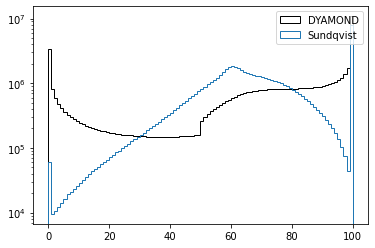

In [20]:
def predict(P,X):
    '''
        The objective function.
    '''
    rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea = P
    preds = np.minimum(np.maximum(func(X, rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea), 0), 100)
    return preds

plt.hist(flattened_output_valid, bins=100, histtype='step', color='k')
plt.hist(predict(res.x, flattened_input_valid),bins=100, histtype='step')

plt.yscale('log')
plt.legend(['DYAMOND', 'Sundqvist'])
plt.savefig('results_Nelder-Mead_tuned_cl_area.pdf')